# Part 2 - Masked Self Attention Notebook 
### Python notebook to get some hands-on to understand the computation of masked self attention scores.
----

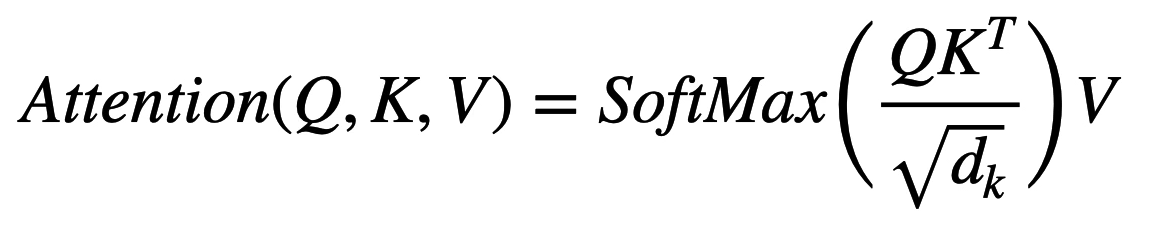

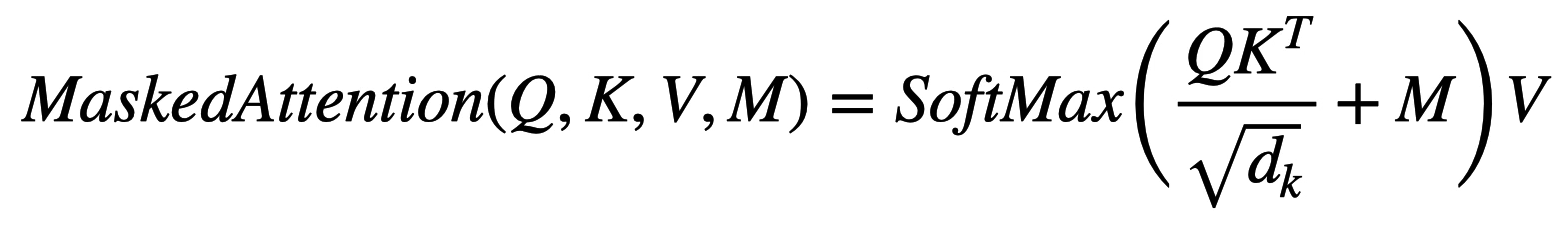

In [2]:
# Importing necessary libraries
import torch
import torch.nn as nn

SEED = 42

In [49]:
# The MaskedSelfAttention class
class MaskedSelfAttention(nn.Module):
    def __init__(self, embed_dim, row_dim=0, col_dim=1):
        torch.manual_seed(SEED)

        super().__init__()
        self.row_dim = row_dim
        self.col_dim = col_dim

        self.W_q = nn.Linear(in_features=embed_dim, out_features=embed_dim, bias=False)
        self.W_k = nn.Linear(in_features=embed_dim, out_features=embed_dim, bias=False)
        self.W_v = nn.Linear(in_features=embed_dim, out_features=embed_dim, bias=False)

    def forward(self, token_encodings, mask=None):
        """
            This method performs the self attention calculations. If mask is None, it acts computes usual self-attention scores, else it computes masked self-attention.
            param:
                token_encodings: Tensor of shape (num_tokens, embed_dim) - Token Embeddings + Position Encodings.
                mask: Mask matrix to add to the similarity_scores to apply masking.

            return:
                attention_scores: Self-Attention Scores for the given token_encodings. The output will be of shape (num_tokens x v.shape[1])
        """ 

        # Here PyTorch will automatically perform token_encodings (num_tokens x embed_dim) @ W_q.T (embed_dim x embed_dim)
        # In our case, this detail doesn't matter much. But in actual transformer architecture, using multi-headed attention W_q weight matrix will be of shape (512 x 64)
        # So 8 attention-heads will give us the final embedding dimension after attention mechanism to be 512 dims
        
        # q, k and v tensors will be of shape (num_tokens X 64) in actual transformer. But in our case it will be (num_tokens x 2[embed_dim])
        q = self.W_q(token_encodings)
        k = self.W_k(token_encodings)
        v = self.W_v(token_encodings)

        similarity_scores = torch.matmul(q, k.T)
        scaled_similarity_scores = similarity_scores / k.shape[-1] ** 0.5

        # Applying masking to mask out the unseen tokens using masked_fill which fills the True positions in the mask matrix to an extremely large number (-1e9).
        if mask is not None:
            scaled_similarity_scores = scaled_similarity_scores.masked_fill(mask=mask, value=-1e9)

        # If there were 20 tokens in the input token_encodings, so technically it would be (20 x embed_dim).
        # Now after applying self-attention, the final attention_probs matrix will be of dim: (20 x 20).
        # If basically gives us the attention_prob (similarity score) of one token against itself and others.
        attention_probs = torch.softmax(scaled_similarity_scores, dim=self.col_dim)

        attention_scores = attention_probs @ v

        return attention_scores

In [50]:
# encodings_matrix of an input sentence "I am Indian" will have 3 tokens and embed_dim in our case of 2. Just a dummy assumption.
# So we embed these tokens and also add the positional encodings to get a (3 x 2) encoding_matrix for the input sentence
encodings_matrix = torch.tensor([[1.16, 0.23],
                                 [0.57, 1.36],
                                 [4.41, -2.16]
                                 ])
mask = torch.tril(torch.ones(encodings_matrix.shape[0], encodings_matrix.shape[0]))
mask = mask == 0

In [51]:
mask

tensor([[False,  True,  True],
        [False, False,  True],
        [False, False, False]])

In [52]:
masked_self_attention = MaskedSelfAttention(embed_dim=2, row_dim=0, col_dim=1)

In [55]:
masked_self_attention_scores = masked_self_attention(encodings_matrix, mask=mask)

In [56]:
masked_self_attention_scores

tensor([[ 0.6038,  0.7434],
        [-0.0062,  0.6072],
        [ 3.4989,  2.2427]], grad_fn=<MmBackward0>)

### Masked Self Attention - Details:
Masked self-attention ensures that when generating output, the decoder only looks at past tokens — so it learns to predict the next token fairly, without cheating.
Input sequence: `Write a Poem`

When predicting:

1] Token 1 ("Write") → can only attend to `["Write"]`

2] Token 2 ("a") → can attend to `["Write", "a"]`

3] Token 3 ("Poem") → can attend to `["Write", "a", "Poem"]`

But it cannot peek at future words while generating! Otherwise, it would `cheat.`
